In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt

import statsmodels.api as sm
from pylab import rcParams

from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading the data
df = pd.read_csv('/content/Time_series_analysis_and_forecast_DATASET.csv')
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [3]:
#Converting FullDate to date time
df['FullDate'] = pd.to_datetime(df['FullDate'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FullDate   92016 non-null  datetime64[ns]
 1   Tmax       92016 non-null  float64       
 2   SysLoad    92016 non-null  float64       
 3   GasPrice   92016 non-null  float64       
 4   ElecPrice  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.5 MB


In [5]:
#set FullDate as index so i can resample 
df.set_index('FullDate',inplace=True)

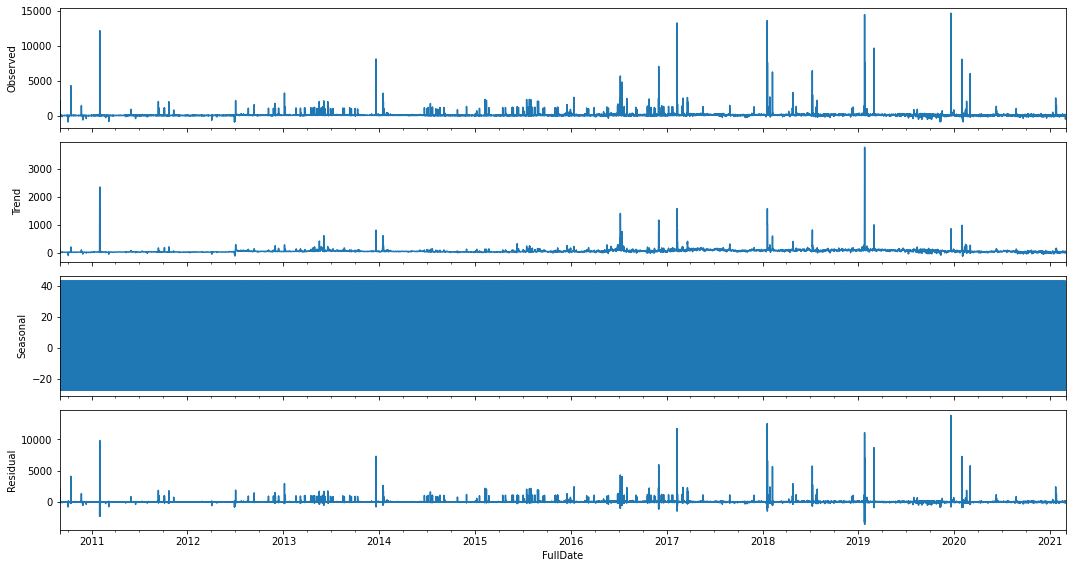

In [6]:
#Exploring the time series using decompose
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(df['ElecPrice'], model='additive')
decompose_series.plot()
plt.show()

In [7]:
#resampling
df_daily = df.resample('D').sum()

In [8]:
df_daily.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [9]:
df_daily.shape[0]

3834

In [10]:
#splitting into train and test
train_df = df_daily[:2757]
test_df = df_daily[2757:]

In [11]:
train_df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [12]:
#resetting index so i can have the FullDate as columns
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [13]:
train_df = train_df.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
train_df = train_df[['ds', 'y']]
train_df.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [14]:
#Model building and fitting data
model = Prophet()
model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
#checking future period
3834-2757

1077

In [16]:
#Prediction
uni_var_future = model.make_future_dataframe(periods=1077, freq='D') 
univar_forecast = model.predict(uni_var_future)

In [17]:
univar_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3829,2021-02-24,3475.863766,826.335575,6351.531255
3830,2021-02-25,3542.743730,533.602437,6398.384450
3831,2021-02-26,3309.660718,384.231619,6488.462088
3832,2021-02-27,2966.465610,53.529884,6057.910592
3833,2021-02-28,2878.477834,65.455853,5700.053565


In [18]:
test_df = test_df.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
test_df = test_df[['ds', 'y']]
test_df.head()

,ds,y
0,2018-03-20,1833.00
1,2018-03-21,1730.49
2,2018-03-22,2260.55
3,2018-03-23,2138.76
4,2018-03-24,1721.70


### Metrics 

In [19]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return round(np.mean(np.abs((actual - pred)/ actual)) * 100, 2)

In [20]:
mape(test_df['y'],univar_forecast['yhat'][2757:])

549.48

In [21]:
mse = mean_squared_error(test_df['y'], univar_forecast['yhat'][2757:])
rmse = round(np.sqrt(mse), 2)

In [22]:
rmse

3218.16

### Model Plots

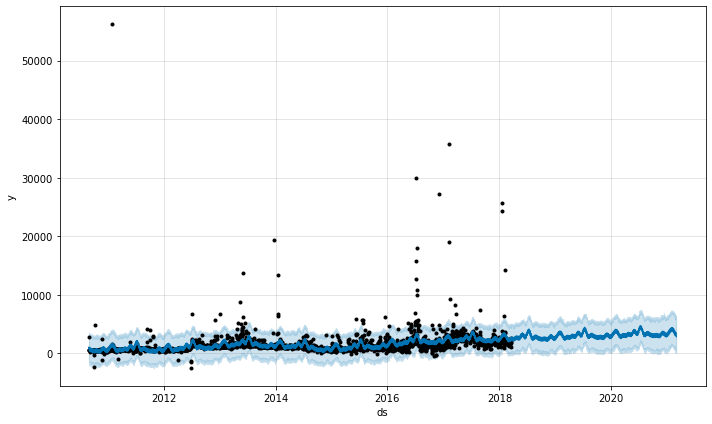

In [23]:
model.plot(univar_forecast); #The semi-colon is to avoid duplicate/redundant plots

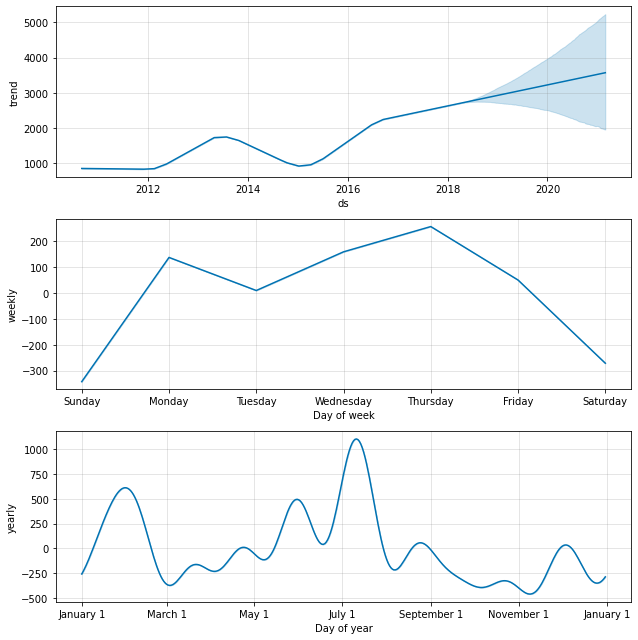

In [24]:
model.plot_components(univar_forecast);

### Multivariate analysis


In the last exercise, we used only the dependent variable (ElecPrice) and the time component for our modeling (ds vs y). Next, we will build a time series model using the other variables. These variables will be added to the forecast model as a regressor on Facebook Prophet. So the 3 independent variables [‘SysLoad’,’Tmax’,’GasPrice’'] will be [‘add1’, ‘add2’, ‘add3’’] as the regressors. Split the data into train and test as done above and build a multivariate forecast model to forecast the last x-2757 days of ElecPrice. Answer question 17-19:

In [25]:
#Getting data 
multi_var_data = df_daily.reset_index().rename(columns={"FullDate": "ds", "ElecPrice": "y", 'SysLoad': 'add1', 'Tmax': 'add2', 'GasPrice': 'add3'})
multi_var_data.head()

,ds,add2,add1,add3,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [26]:
#splitting into train test
train_multi_var = multi_var_data[:2757]
test_multi_var = multi_var_data[2757:]

In [27]:
#Model
model_new = Prophet()

In [28]:
#Adding regressors
model_new.add_regressor('add2')
model_new.add_regressor('add1')
model_new.add_regressor('add3')

In [29]:
#fitting data
model_new.fit(train_multi_var)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
multivar_future = model_new.make_future_dataframe(periods=1077)
multivar_future.tail()

,ds
3829,2021-02-24
3830,2021-02-25
3831,2021-02-26
3832,2021-02-27
3833,2021-02-28


In [31]:
multivar_future.shape

(3834, 1)

In [32]:
train_multi_var.shape

(2757, 5)

In [33]:
multivar_future['add2'] = multi_var_data['add2']
multivar_future['add1'] = multi_var_data['add1']
multivar_future['add3'] = multi_var_data['add3']

In [34]:
#making predictions
multivar_forecast = model_new.predict(multivar_future)
multivar_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-01,985.569713,-698.408438,3792.072587,985.569713,985.569713,1038.466865,1038.466865,1038.466865,0.250373,...,42.487809,42.487809,42.487809,-4.291446,-4.291446,-4.291446,0.0,0.0,0.0,1506.402210
1,2010-09-02,986.126153,-662.815653,3691.537780,986.126153,986.126153,889.288340,889.288340,889.288340,0.251234,...,145.592749,145.592749,145.592749,-7.176762,-7.176762,-7.176762,0.0,0.0,0.0,1458.000610
2,2010-09-03,986.682593,-658.265122,3927.406956,986.682593,986.682593,1044.082901,1044.082901,1044.082901,0.244990,...,-44.332666,-44.332666,-44.332666,-10.122262,-10.122262,-10.122262,0.0,0.0,0.0,1687.666557
3,2010-09-04,987.239034,-1320.516744,2960.720441,987.239034,987.239034,706.848037,706.848037,706.848037,0.254894,...,-117.498131,-117.498131,-117.498131,-12.857966,-12.857966,-12.857966,0.0,0.0,0.0,902.434197
4,2010-09-05,987.795474,-886.282973,3551.205449,987.795474,987.795474,705.355630,705.355630,705.355630,0.252310,...,-69.444190,-69.444190,-69.444190,-15.141122,-15.141122,-15.141122,0.0,0.0,0.0,1319.929104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,2021-02-24,2601.752905,-1569.187834,3414.615162,1830.662189,3301.738274,-1372.370844,-1372.370844,-1372.370844,0.236162,...,42.487809,42.487809,42.487809,-433.624659,-433.624659,-433.624659,0.0,0.0,0.0,953.896217
3830,2021-02-25,2602.439338,-946.315516,3568.195203,1830.140701,3303.721507,-1033.071453,-1033.071453,-1033.071453,0.237885,...,145.592749,145.592749,145.592749,-460.046399,-460.046399,-460.046399,0.0,0.0,0.0,1313.507388
3831,2021-02-26,2603.125772,-921.896370,3606.329061,1829.619212,3305.704740,-754.566580,-754.566580,-754.566580,0.235301,...,-44.332666,-44.332666,-44.332666,-480.697066,-480.697066,-480.697066,0.0,0.0,0.0,1377.373852
3832,2021-02-27,2603.812205,-1389.538714,3265.561047,1829.097723,3307.687972,-1011.039138,-1011.039138,-1011.039138,0.233794,...,-117.498131,-117.498131,-117.498131,-495.339277,-495.339277,-495.339277,0.0,0.0,0.0,1032.301956


In [35]:
multivar_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3829,2021-02-24,953.896217,-1569.187834,3414.615162
3830,2021-02-25,1313.507388,-946.315516,3568.195203
3831,2021-02-26,1377.373852,-921.896370,3606.329061
3832,2021-02-27,1032.301956,-1389.538714,3265.561047
3833,2021-02-28,1192.779471,-1150.694833,3446.503765


### Model Plots

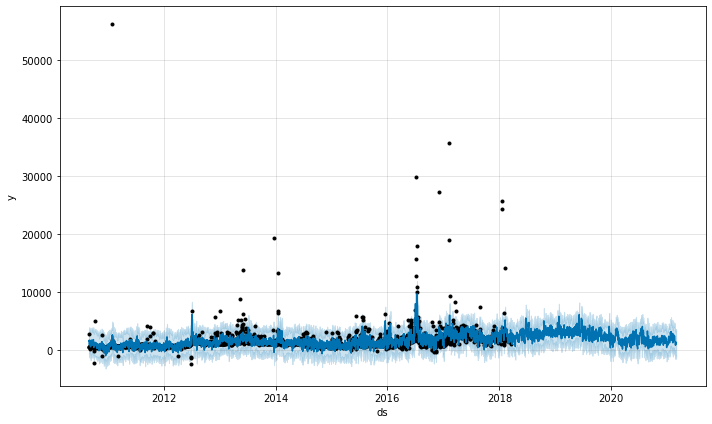

In [36]:
model_new.plot(multivar_forecast);

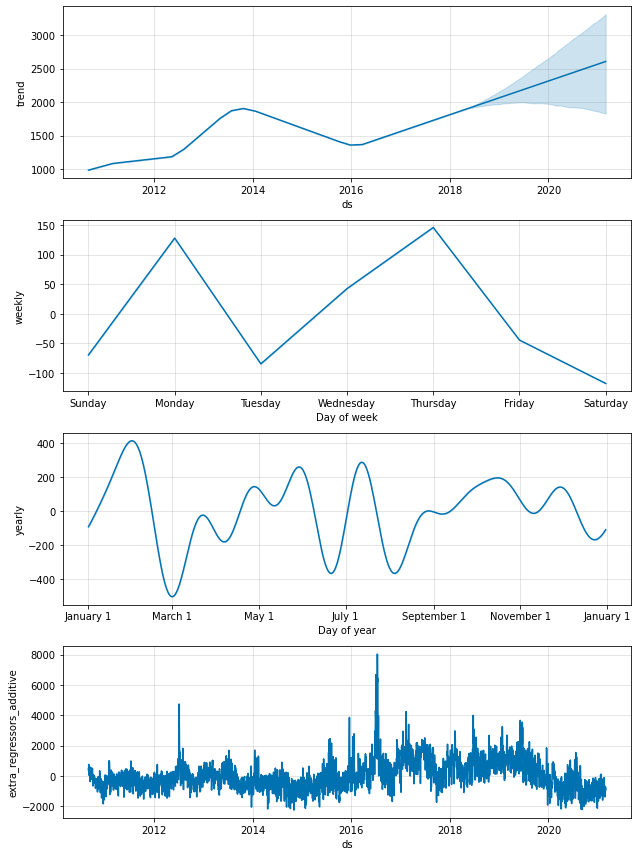

In [37]:
model_new.plot_components(multivar_forecast);

In [38]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return round(np.mean(np.abs((actual - pred)/ actual)) * 100, 2)

In [39]:
mape(test_multi_var['y'],multivar_forecast['yhat'][2757:])

231.38

In [40]:
mse = mean_squared_error(test_multi_var['y'], multivar_forecast['yhat'][2757:])
rmse = round(np.sqrt(mse), 2)
rmse

2707.04

Question 12 and 13

In [42]:
from statsmodels.tsa.stattools import adfuller

In [44]:
result = adfuller(df_daily['SysLoad'])
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -3.6901589888366457
n_lags: 0.004253725504574117
p-value: 0.004253725504574117
Critial Values:
   1%, -3.432070672988693
Critial Values:
   5%, -2.8623002987378547
Critial Values:
   10%, -2.567174716967499


In [45]:
result = adfuller(df_daily['GasPrice'])
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -2.90276669716518
n_lags: 0.04502721288462542
p-value: 0.04502721288462542
Critial Values:
   1%, -3.4320693157877544
Critial Values:
   5%, -2.8622996992165364
Critial Values:
   10%, -2.5671743978048323


In [46]:
result = adfuller(df_daily['GasPrice'])
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -2.90276669716518
n_lags: 0.04502721288462542
p-value: 0.04502721288462542
Critial Values:
   1%, -3.4320693157877544
Critial Values:
   5%, -2.8622996992165364
Critial Values:
   10%, -2.5671743978048323


In [47]:
result = adfuller(df_daily['ElecPrice'])
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -8.269053866873803
n_lags: 4.848817773711633e-13
p-value: 4.848817773711633e-13
Critial Values:
   1%, -3.432066157296446
Critial Values:
   5%, -2.8622983040036005
Critial Values:
   10%, -2.5671736550459663


Question 20

In [48]:
new_data = multi_var_data.drop('add2',axis=1)

new_train_multi_var = new_data[:2757]
new_test_multi_var = new_data[2757:]

latest_model = Prophet()

latest_model.add_regressor('add1')
latest_model.add_regressor('add3')

latest_model.fit(new_train_multi_var)

new_future = latest_model.make_future_dataframe(periods=1077)

new_future['add1'] = new_data['add1']
new_future['add3'] = new_data['add3']

latest_forecast = latest_model.predict(new_future)

mape(new_test_multi_var['y'],latest_forecast['yhat'][2757:])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


236.66

Question 11

In [49]:
hourly_data = df.resample('H').sum()

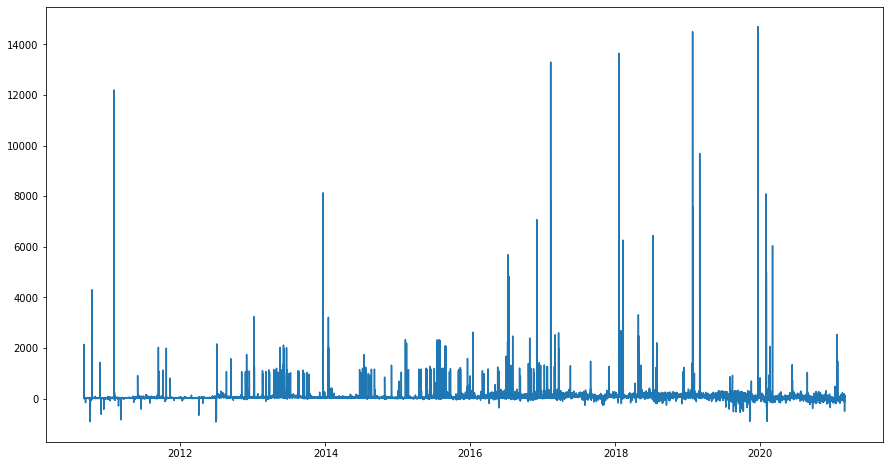

In [52]:
plt.plot(hourly_data['ElecPrice'])

In [50]:
hourly_data.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030
